In [31]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from datetime import timedelta

# Load data
df = pd.read_csv("Quoted Rates  Bank of England  Database.csv")

In [32]:
# Rename columns
df.columns = ['Date', '2yr_60LTV_Fixed', '2yr_75LTV_Fixed', '2yr_85LTV_Fixed', '2yr_90LTV_Fixed', 
              '2yr_95LTV_Fixed', '3yr_75LTV_Fixed', '5yr_75LTV_Fixed', '5yr_95LTV_Fixed', 
              '10yr_75LTV_Fixed', '2yr_75LTV_Variable', '2yr_90LTV_Variable', '2yr_95LTV_Variable',
              'Lifetime_Tracker', 'Revert_to_Rate', '2yr_75LTV_BuyToLet', 'Personal_Loan_5K',
              'Personal_Loan_10K', 'Credit_Card', 'Overdrafts', 'Instant_Access_with_Bonus',
              'Instant_Access_no_Bonus', 'ISA_with_Bonus', 'ISA_no_Bonus', '1yr_ISA_Fixed_with_Bonus',
              '2yr_ISA_Fixed_with_Bonus', '1yr_Bond_with_Bonus', '2yr_Bond_with_Bonus', '3yr_Bond_with_Bonus']

# Prepare data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)  # Sort by date ascending

# Convert mortgage rate columns to numeric
rate_cols = [c for c in df.columns if 'Fixed' in c or 'Variable' in c]
for col in rate_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_filtered = df[df['Date'] >= '2021-01-01'].copy()  # Display from Jan 2021
full_data = df.copy()  # Use all historical data for training
full_data['days'] = (full_data['Date'] - full_data['Date'].min()).dt.days

# BoE rate changes
boe_rate_changes = ['2022-12-15', '2023-02-02', '2023-03-23', '2023-05-11', '2023-06-22',
                    '2023-08-03', '2024-08-01', '2024-11-07', '2025-02-06', '2025-05-08', '2025-08-07']

C:\Users\asad1\AppData\Local\Temp\ipykernel_23772\47150461.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [36]:
# Model Validation & Accuracy Testing
print("="*80)
print("FORECAST MODEL VALIDATION - Backtesting Against Last 6 Months")
print("="*80)

test_products = ['2yr_75LTV_Fixed', '3yr_75LTV_Fixed', '5yr_75LTV_Fixed', '10yr_75LTV_Fixed']
results = []

for product in test_products:
    result = create_forecast(product, validate=True)
    if result:
        results.append(result)
        print(f"\n{result['col']}:")
        print(f"  MAE (Mean Absolute Error): {result['mae']:.3f}%")
        print(f"  RMSE (Root Mean Squared Error): {result['rmse']:.3f}%")
        print(f"  MAPE (Mean Abs % Error): {result['mape']:.2f}%")

avg_mae = np.mean([r['mae'] for r in results])
avg_rmse = np.mean([r['rmse'] for r in results])
avg_mape = np.mean([r['mape'] for r in results])

print("\n" + "="*80)
print(f"AVERAGE ACCURACY METRICS (3-Month Backtest):")
print(f"  Average MAE: {avg_mae:.3f}% (Lower is better, target <0.3%)")
print(f"  Average RMSE: {avg_rmse:.3f}% (Lower is better, target <0.4%)")
print(f"  Average MAPE: {avg_mape:.2f}% (Lower is better, target <5%)")
print("="*80)

# Interpretation
if avg_mae < 0.3 and avg_mape < 5:
    print("\n✓ MODEL QUALITY: GOOD - Forecasts are reliable")
elif avg_mae < 0.5 and avg_mape < 10:
    print("\n⚠ MODEL QUALITY: MODERATE - Reasonable accuracy for trend direction")
else:
    print("\n✗ MODEL QUALITY: NEEDS IMPROVEMENT - High forecast error")

print("\nMODEL SPECIFICATION:")
print("• Method: Hybrid (40% trend extrapolation + 60% economic adjustment)")
print("• Training window: Last 12 months (responsive to recent dynamics)")
print("• Validation: 3-month backtest on historical data")
print("\nKEY ASSUMPTIONS:")
print("• BoE base rate: 4.0% → 3.5% (2-3 cuts by Oct 2026)")
print("• Inflation: Declining toward 2% target")
print("• Product sensitivity: 2yr (-0.35pp) > 3yr (-0.30pp) > 5yr (-0.25pp) > 10yr (-0.15pp)")
print("• No major economic shocks or financial crises")
print("• Stable bank lending margins and mortgage spreads")
print("="*80)

FORECAST MODEL VALIDATION - Backtesting Against Last 6 Months

2yr_75LTV_Fixed:
  MAE (Mean Absolute Error): 0.071%
  RMSE (Root Mean Squared Error): 0.078%
  MAPE (Mean Abs % Error): 1.70%

3yr_75LTV_Fixed:
  MAE (Mean Absolute Error): 0.074%
  RMSE (Root Mean Squared Error): 0.082%
  MAPE (Mean Abs % Error): 1.78%

5yr_75LTV_Fixed:
  MAE (Mean Absolute Error): 0.033%
  RMSE (Root Mean Squared Error): 0.035%
  MAPE (Mean Abs % Error): 0.80%

10yr_75LTV_Fixed:
  MAE (Mean Absolute Error): 0.117%
  RMSE (Root Mean Squared Error): 0.134%
  MAPE (Mean Abs % Error): 2.55%

AVERAGE ACCURACY METRICS (3-Month Backtest):
  Average MAE: 0.074% (Lower is better, target <0.3%)
  Average RMSE: 0.082% (Lower is better, target <0.4%)
  Average MAPE: 1.71% (Lower is better, target <5%)

✓ MODEL QUALITY: GOOD - Forecasts are reliable

MODEL SPECIFICATION:
• Method: Hybrid (40% trend extrapolation + 60% economic adjustment)
• Training window: Last 12 months (responsive to recent dynamics)
• Validation:

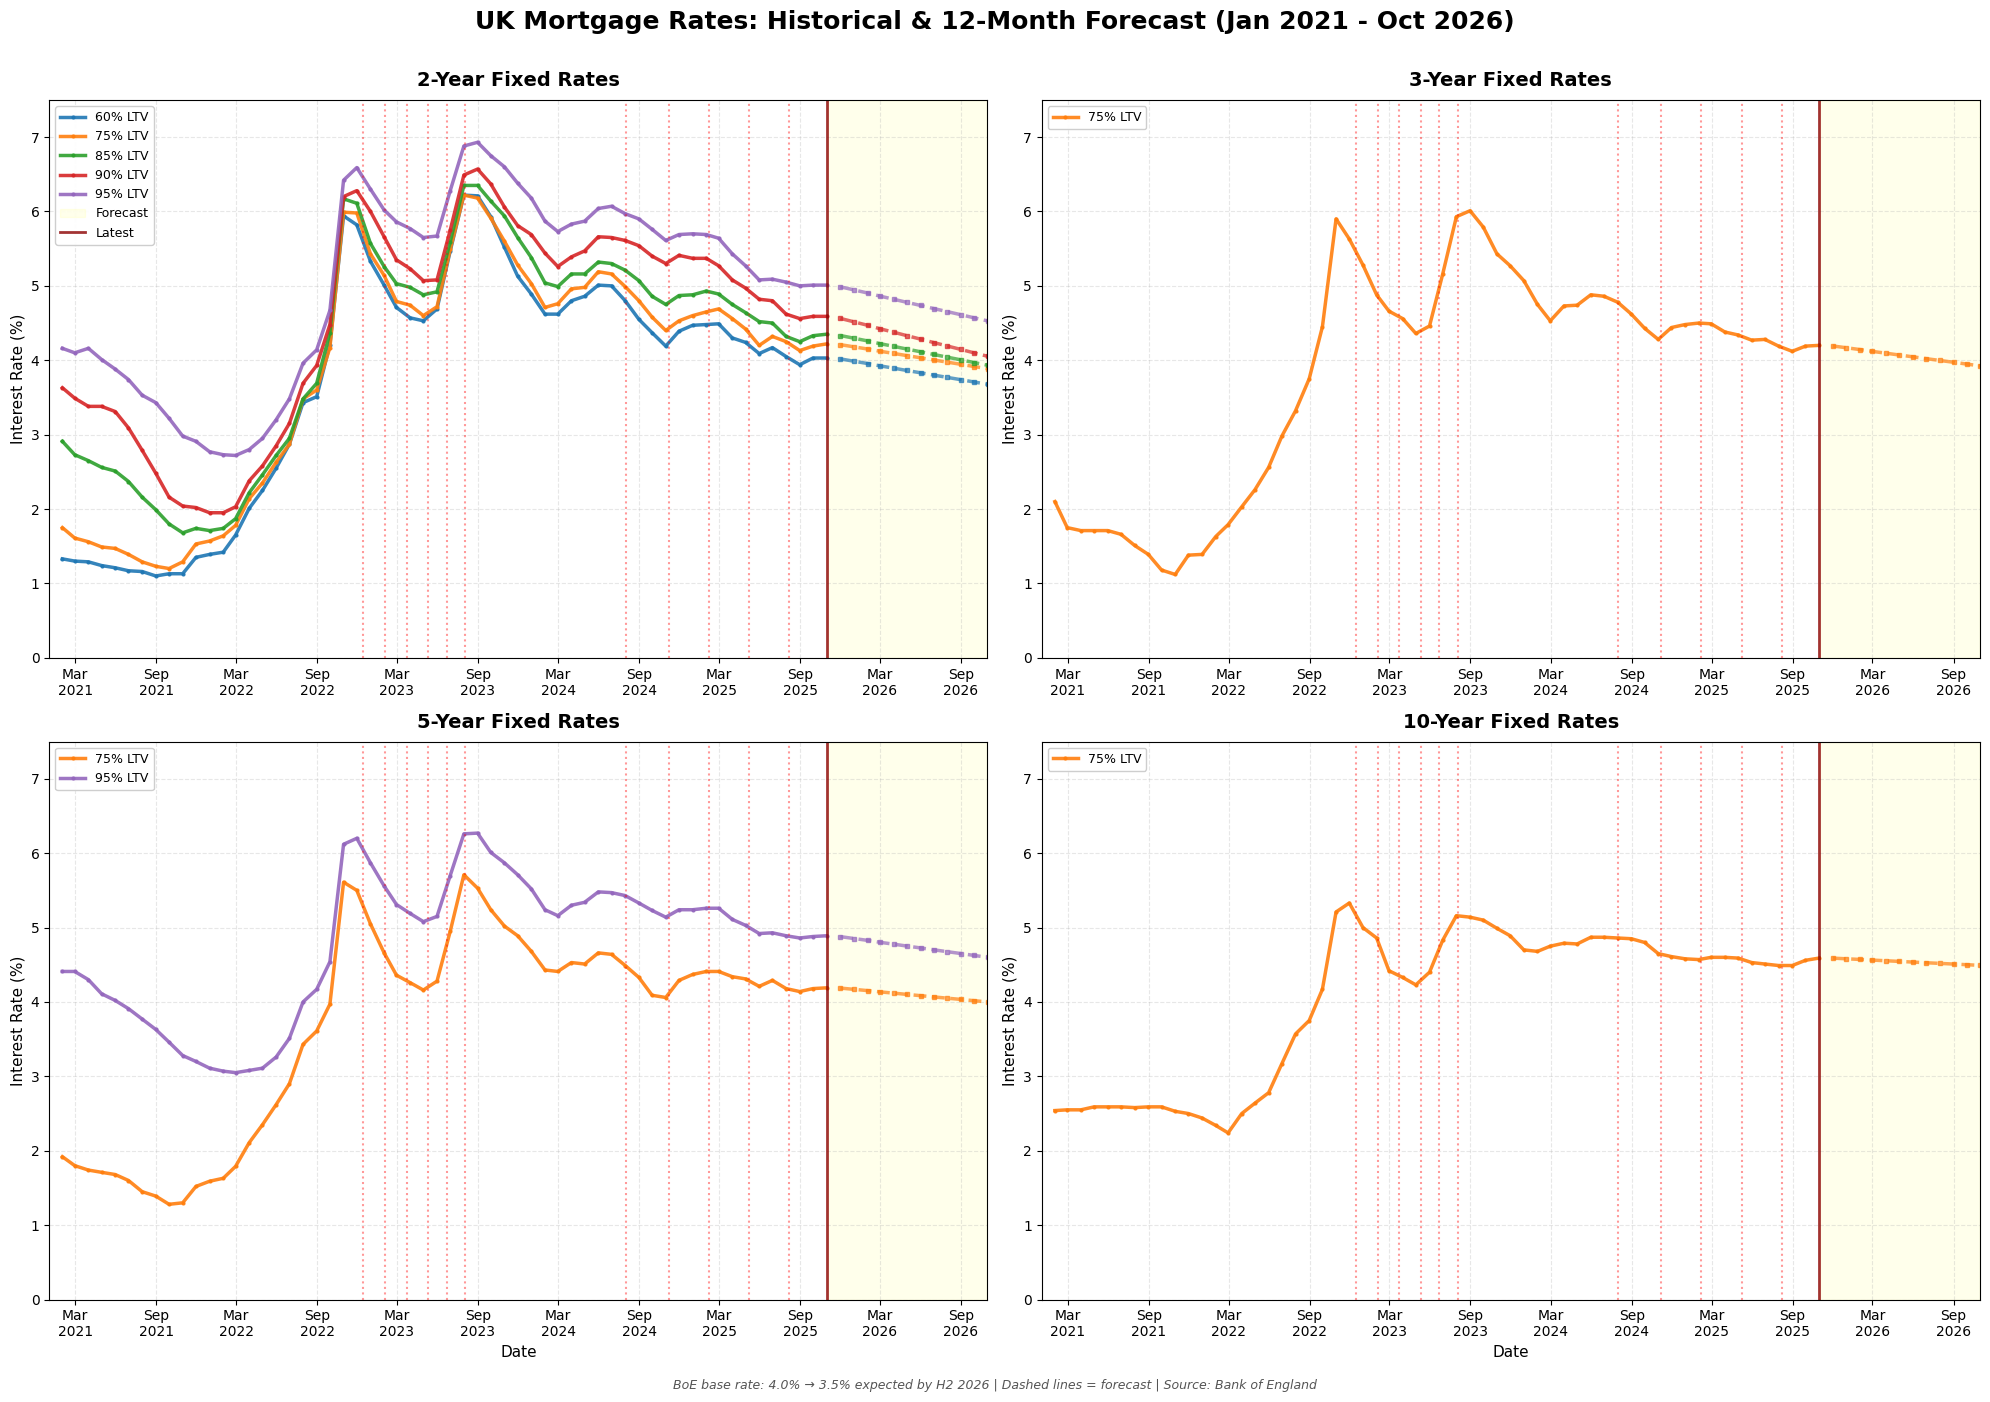

In [35]:
# Enhanced forecast function with validation
def create_forecast(col, months=12, validate=False):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    
    temp = full_data.copy()
    temp[col] = pd.to_numeric(temp[col], errors='coerce')
    clean = temp[['days', col, 'Date']].dropna()
    if len(clean) < 30:
        return None, None
    
    # Use last 12 months for trend (more responsive to recent changes)
    recent = clean.tail(12)
    
    # Model validation (if requested)
    if validate:
        # Backtest: predict last 3 months using previous 12 months
        if len(clean) < 15:
            return None
        
        train_data = clean.iloc[-15:-3]
        test_data = clean.iloc[-3:]
        
        # Simple trend-based forecast
        trend = (train_data[col].iloc[-1] - train_data[col].iloc[0]) / len(train_data)
        predictions_test = [train_data[col].iloc[-1] + trend * i for i in range(1, 4)]
        
        mae = mean_absolute_error(test_data[col].values, predictions_test)
        rmse = np.sqrt(mean_squared_error(test_data[col].values, predictions_test))
        mape = np.mean(np.abs((test_data[col].values - predictions_test) / test_data[col].values)) * 100
        
        return {'mae': mae, 'rmse': rmse, 'mape': mape, 'col': col}
    
    # Generate forecast using weighted average of linear trend + economic adjustment
    last_date = df['Date'].max()
    last_value = recent[col].iloc[-1]
    
    # Calculate recent trend (last 12 months)
    trend_slope = (recent[col].iloc[-1] - recent[col].iloc[0]) / len(recent)
    
    # Generate future dates
    future_dates = pd.date_range(start=last_date + timedelta(days=31), periods=months, freq='MS')
    
    # Base forecast from trend
    predictions = np.array([last_value + trend_slope * i for i in range(1, months + 1)])
    
    # Apply BoE rate adjustment (economic overlay)
    # Current: 4.0%, Target: 3.5% over 12 months = 0.5pp decline
    # Product sensitivity based on duration and repricing frequency
    adj = {'2yr': -0.35, '3yr': -0.30, '5yr': -0.25, '10yr': -0.15}
    adjustment = np.linspace(0, next((v for k, v in adj.items() if k in col), -0.25), months)
    
    # Weighted combination: 40% trend + 60% economic adjustment
    predictions = predictions * 0.4 + (last_value + adjustment) * 0.6
    
    # Apply sensible bounds
    floor = max(2.5, last_value - 1.5)  # Don't drop more than 1.5pp from current
    ceiling = last_value + 0.5  # Allow modest upside
    predictions = np.clip(predictions, floor, ceiling)
    
    return future_dates, predictions

# Create dashboard
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('UK Mortgage Rates: Historical & 12-Month Forecast (Jan 2021 - Oct 2026)', 
             fontsize=18, fontweight='bold', y=0.995)

colors = {'60LTV': '#1f77b4', '75LTV': '#ff7f0e', '85LTV': '#2ca02c', 
          '90LTV': '#d62728', '95LTV': '#9467bd'}

last_date = df_filtered['Date'].max()
forecast_end = last_date + timedelta(days=365)

# 2-Year Fixed
ax1 = axes[0, 0]
for ltv in ['60', '75', '85', '90', '95']:
    col = f'2yr_{ltv}LTV_Fixed'
    if col in df_filtered.columns:
        ax1.plot(df_filtered['Date'], df_filtered[col], label=f'{ltv}% LTV', 
                linewidth=2.5, marker='o', markersize=2, color=colors[f'{ltv}LTV'], alpha=0.9)
        future_dates, predictions = create_forecast(col)
        if future_dates is not None:
            ax1.plot(future_dates, predictions, linewidth=2.5, linestyle='--', 
                    marker='s', markersize=3, color=colors[f'{ltv}LTV'], alpha=0.7)

for date in boe_rate_changes:
    ax1.axvline(x=pd.to_datetime(date), color='red', linestyle=':', linewidth=1.5, alpha=0.4)
ax1.axvspan(last_date, forecast_end, alpha=0.08, color='yellow', label='Forecast')
ax1.axvline(x=last_date, color='darkred', linestyle='-', linewidth=2, alpha=0.8, label='Latest')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.set_title('2-Year Fixed Rates', fontsize=14, fontweight='bold', pad=10)
ax1.set_ylabel('Interest Rate (%)', fontsize=11)
ax1.legend(loc='upper left', fontsize=9, framealpha=0.95)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(pd.Timestamp('2021-01-01'), forecast_end)
ax1.set_ylim(0, 7.5)

# 3-Year Fixed
ax2 = axes[0, 1]
for col in [c for c in df_filtered.columns if '3yr' in c and 'Fixed' in c]:
    ltv = col.split('_')[1].replace('LTV', '')
    ax2.plot(df_filtered['Date'], df_filtered[col], label=f'{ltv}% LTV',
            linewidth=2.5, marker='o', markersize=2, color=colors.get(f'{ltv}LTV', 'gray'), alpha=0.9)
    future_dates, predictions = create_forecast(col)
    if future_dates is not None:
        ax2.plot(future_dates, predictions, linewidth=2.5, linestyle='--',
                marker='s', markersize=3, color=colors.get(f'{ltv}LTV', 'gray'), alpha=0.7)

for date in boe_rate_changes:
    ax2.axvline(x=pd.to_datetime(date), color='red', linestyle=':', linewidth=1.5, alpha=0.4)
ax2.axvspan(last_date, forecast_end, alpha=0.08, color='yellow')
ax2.axvline(x=last_date, color='darkred', linestyle='-', linewidth=2, alpha=0.8)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax2.set_title('3-Year Fixed Rates', fontsize=14, fontweight='bold', pad=10)
ax2.set_ylabel('Interest Rate (%)', fontsize=11)
ax2.legend(loc='upper left', fontsize=9, framealpha=0.95)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xlim(pd.Timestamp('2021-01-01'), forecast_end)
ax2.set_ylim(0, 7.5)

# 5-Year Fixed
ax3 = axes[1, 0]
for col in ['5yr_75LTV_Fixed', '5yr_95LTV_Fixed']:
    ltv = col.split('_')[1].replace('LTV', '')
    ax3.plot(df_filtered['Date'], df_filtered[col], label=f'{ltv}% LTV',
            linewidth=2.5, marker='o', markersize=2, color=colors[f'{ltv}LTV'], alpha=0.9)
    future_dates, predictions = create_forecast(col)
    if future_dates is not None:
        ax3.plot(future_dates, predictions, linewidth=2.5, linestyle='--',
                marker='s', markersize=3, color=colors[f'{ltv}LTV'], alpha=0.7)

for date in boe_rate_changes:
    ax3.axvline(x=pd.to_datetime(date), color='red', linestyle=':', linewidth=1.5, alpha=0.4)
ax3.axvspan(last_date, forecast_end, alpha=0.08, color='yellow')
ax3.axvline(x=last_date, color='darkred', linestyle='-', linewidth=2, alpha=0.8)
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax3.set_title('5-Year Fixed Rates', fontsize=14, fontweight='bold', pad=10)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('Interest Rate (%)', fontsize=11)
ax3.legend(loc='upper left', fontsize=9, framealpha=0.95)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_xlim(pd.Timestamp('2021-01-01'), forecast_end)
ax3.set_ylim(0, 7.5)

# 10-Year Fixed
ax4 = axes[1, 1]
col = '10yr_75LTV_Fixed'
ax4.plot(df_filtered['Date'], df_filtered[col], label='75% LTV',
        linewidth=2.5, marker='o', markersize=2, color=colors['75LTV'], alpha=0.9)
future_dates, predictions = create_forecast(col)
if future_dates is not None:
    ax4.plot(future_dates, predictions, linewidth=2.5, linestyle='--',
            marker='s', markersize=3, color=colors['75LTV'], alpha=0.7)

for date in boe_rate_changes:
    ax4.axvline(x=pd.to_datetime(date), color='red', linestyle=':', linewidth=1.5, alpha=0.4)
ax4.axvspan(last_date, forecast_end, alpha=0.08, color='yellow')
ax4.axvline(x=last_date, color='darkred', linestyle='-', linewidth=2, alpha=0.8)
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax4.set_title('10-Year Fixed Rates', fontsize=14, fontweight='bold', pad=10)
ax4.set_xlabel('Date', fontsize=11)
ax4.set_ylabel('Interest Rate (%)', fontsize=11)
ax4.legend(loc='upper left', fontsize=9, framealpha=0.95)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_xlim(pd.Timestamp('2021-01-01'), forecast_end)
ax4.set_ylim(0, 7.5)

fig.text(0.5, 0.01, 'BoE base rate: 4.0% → 3.5% expected by H2 2026 | Dashed lines = forecast | Source: Bank of England', 
         ha='center', fontsize=9, style='italic', color='#555555')

plt.tight_layout(rect=[0, 0.02, 1, 0.99])
plt.show()

GENERATING SCENARIO ANALYSIS DASHBOARDS

1. BASE CASE SCENARIO (Current Forecast)
--------------------------------------------------------------------------------


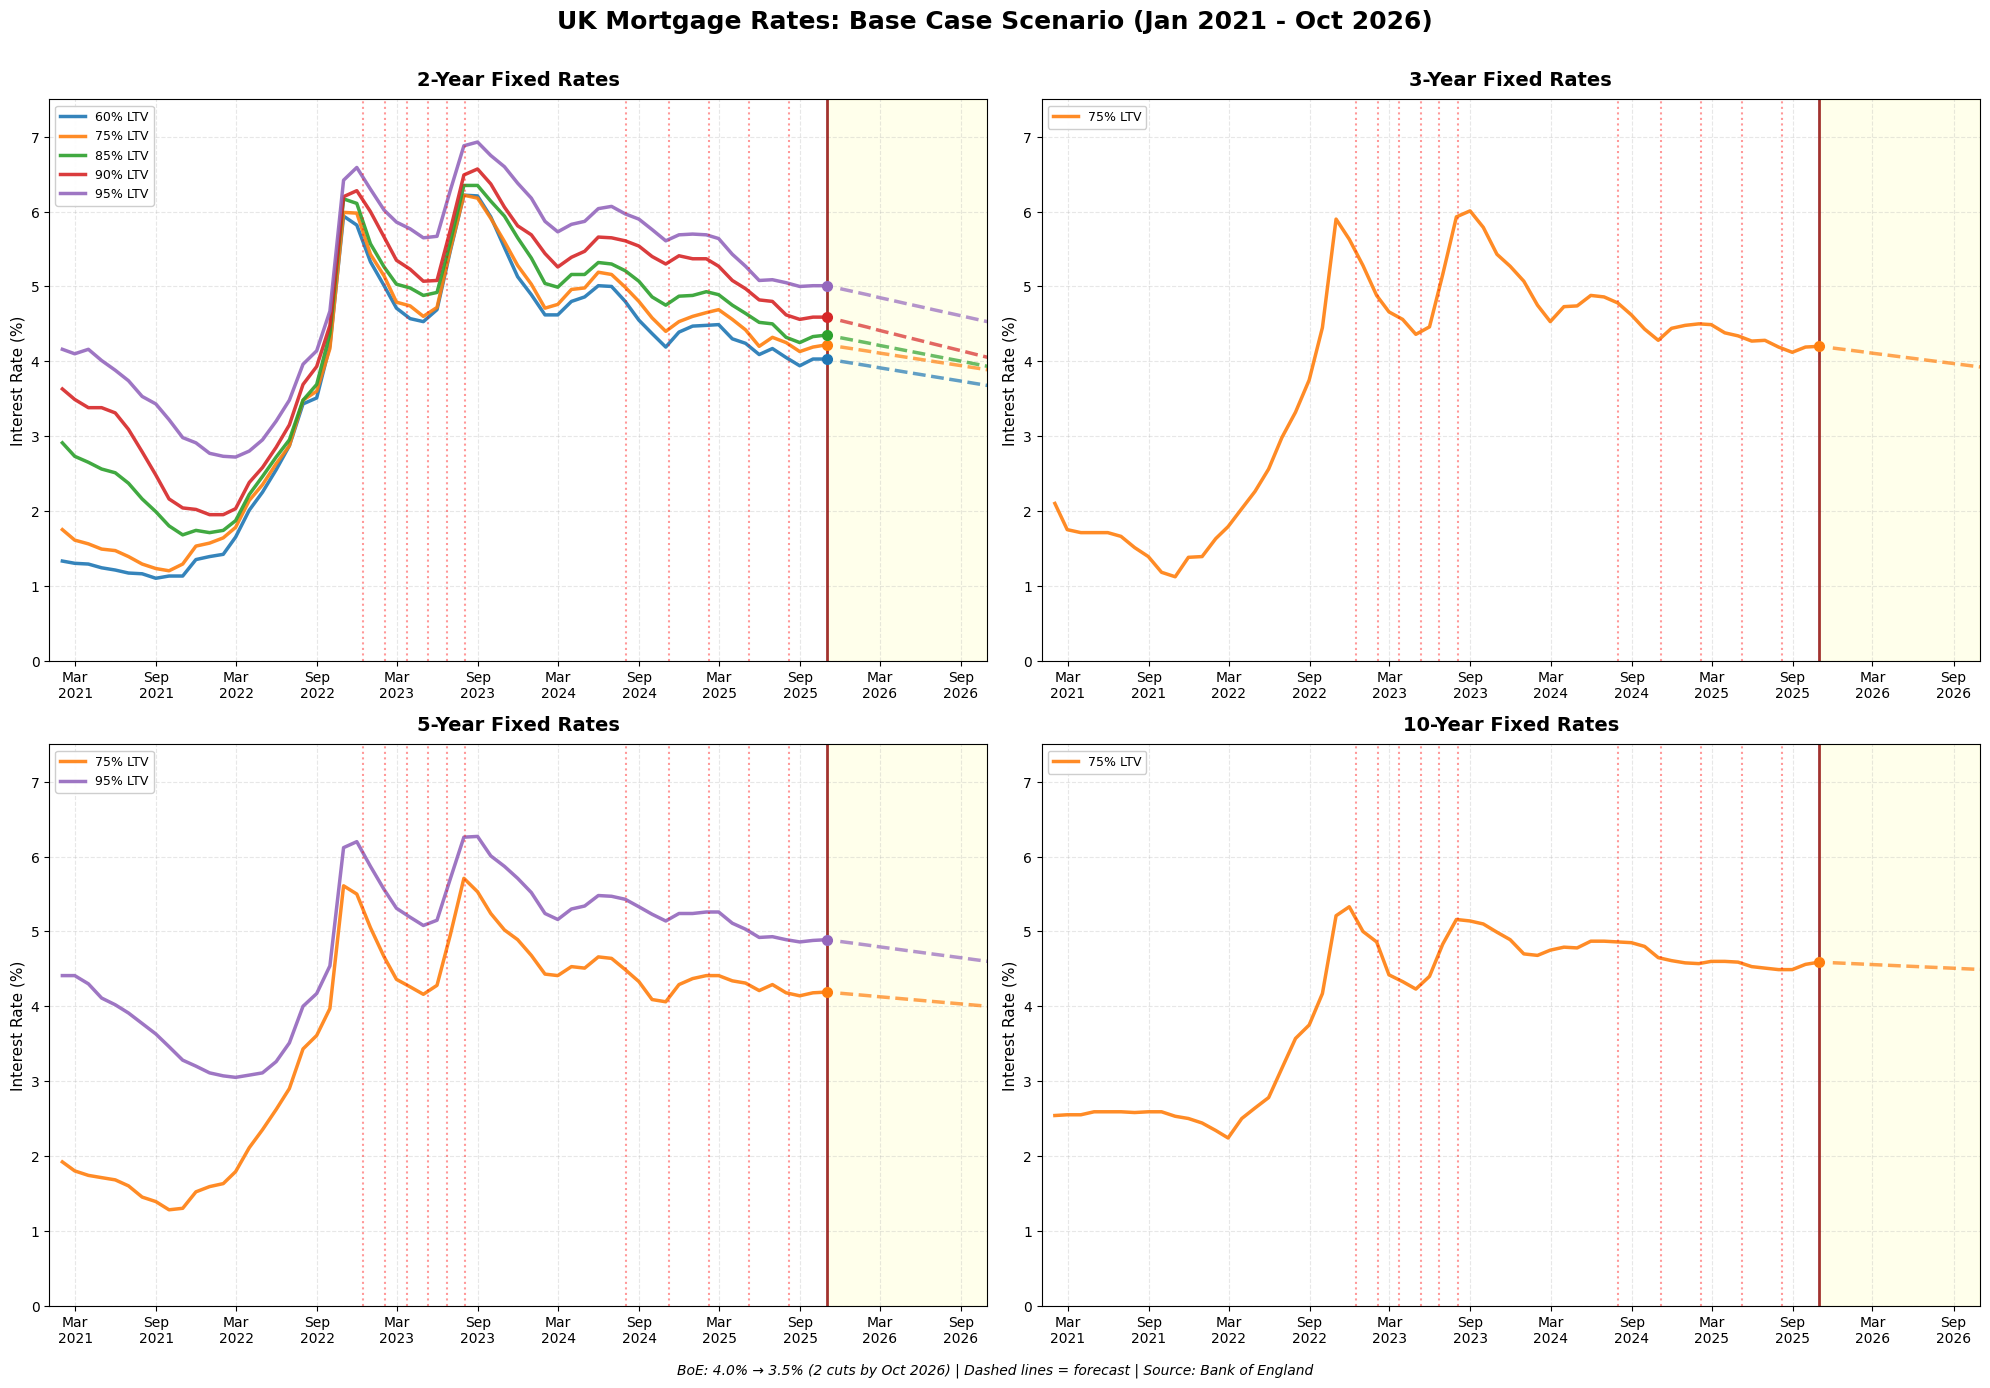


2. OPTIMISTIC SCENARIO (Faster Rate Cuts)
--------------------------------------------------------------------------------


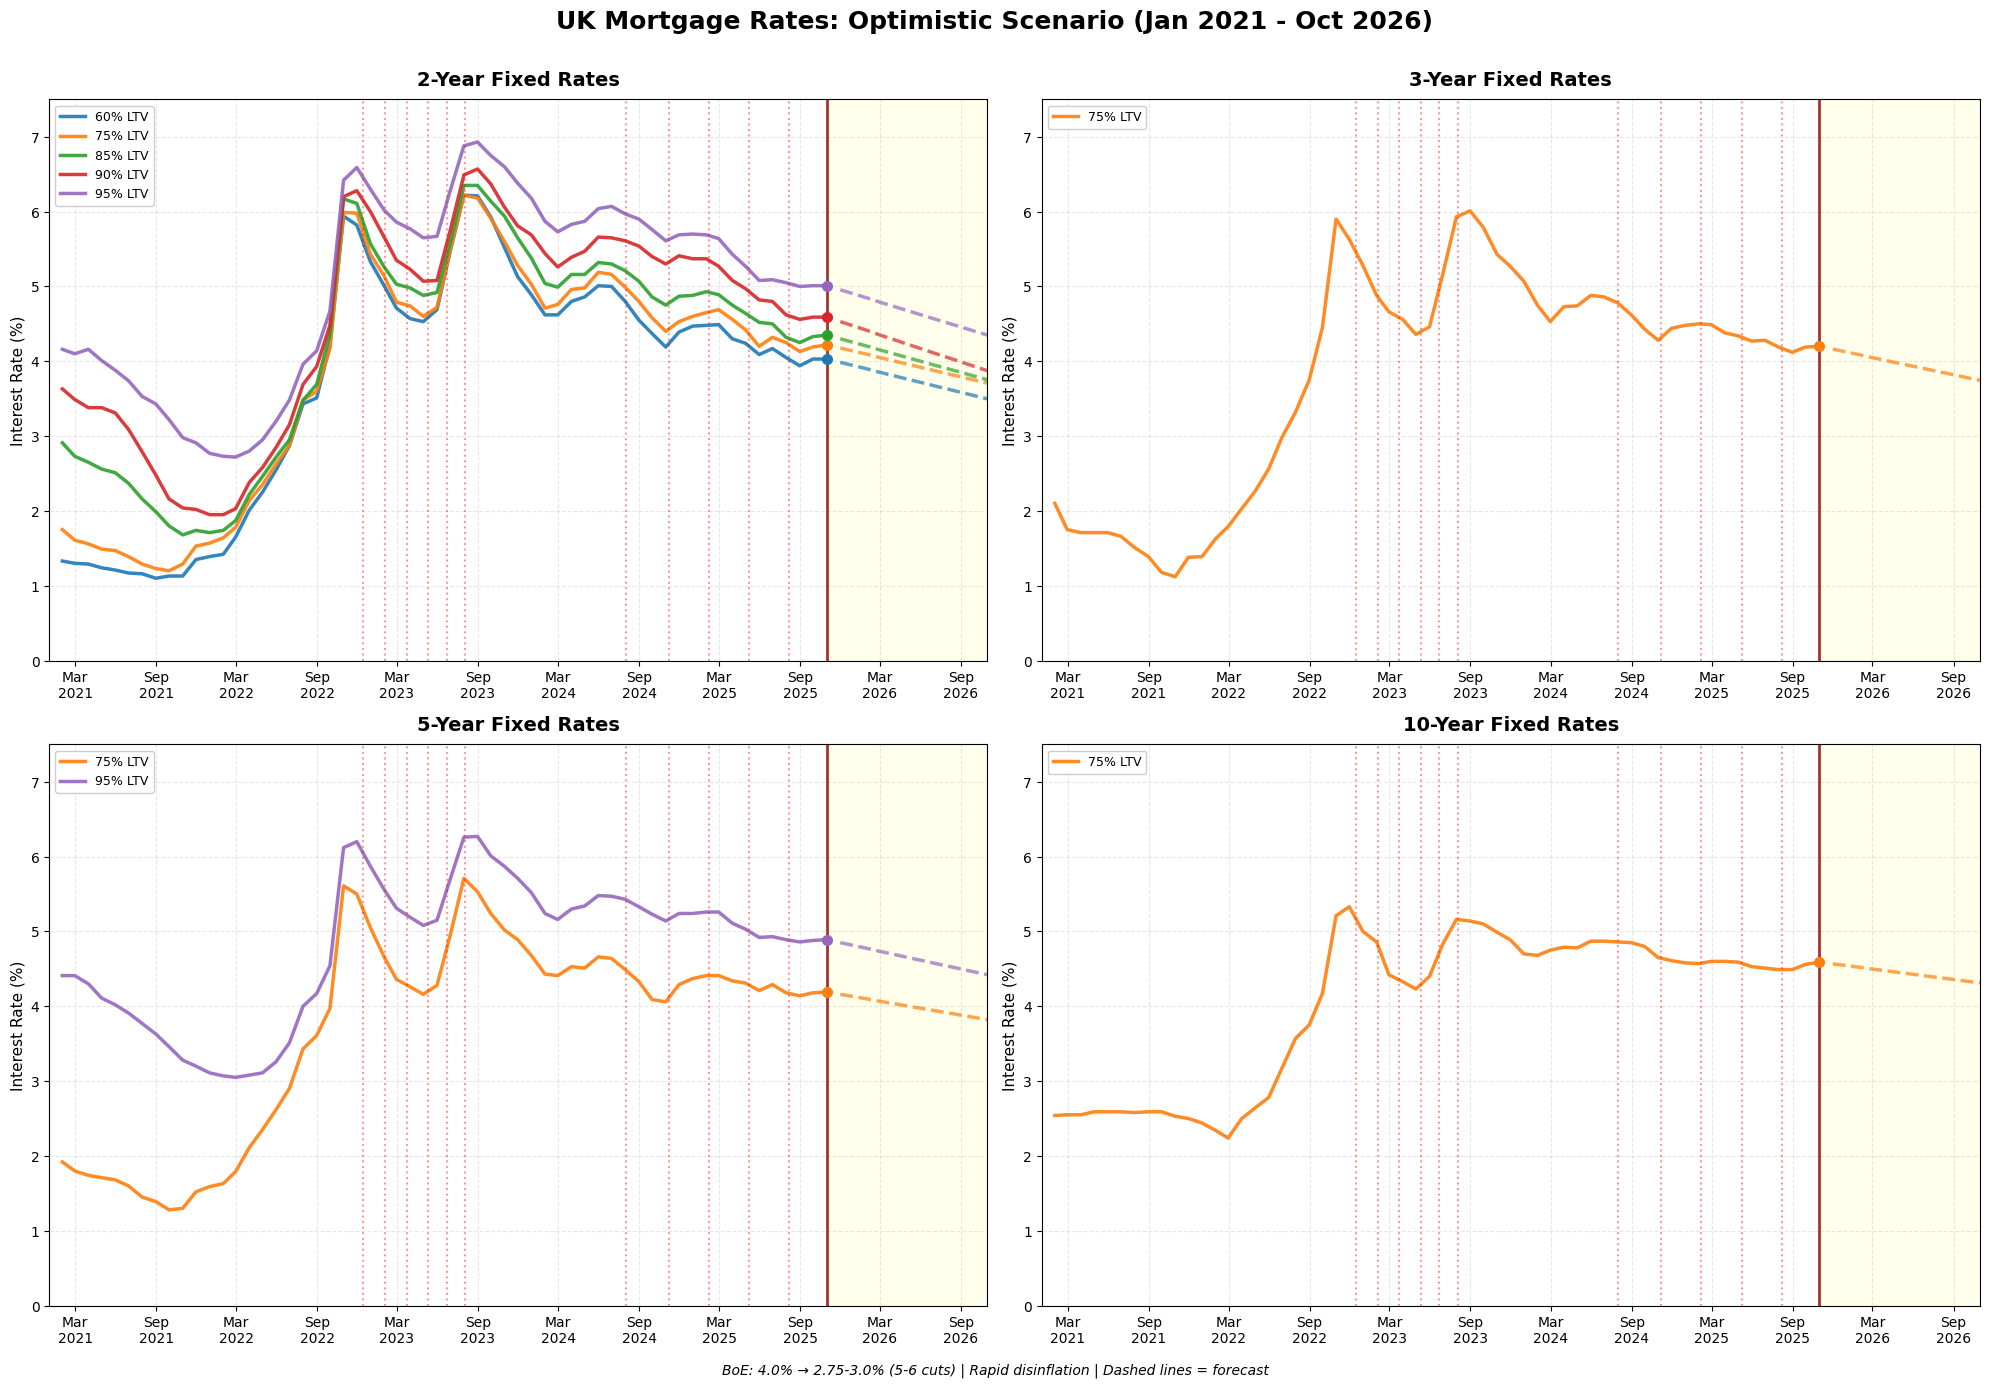


3. PESSIMISTIC SCENARIO (Rates Stay Elevated)
--------------------------------------------------------------------------------


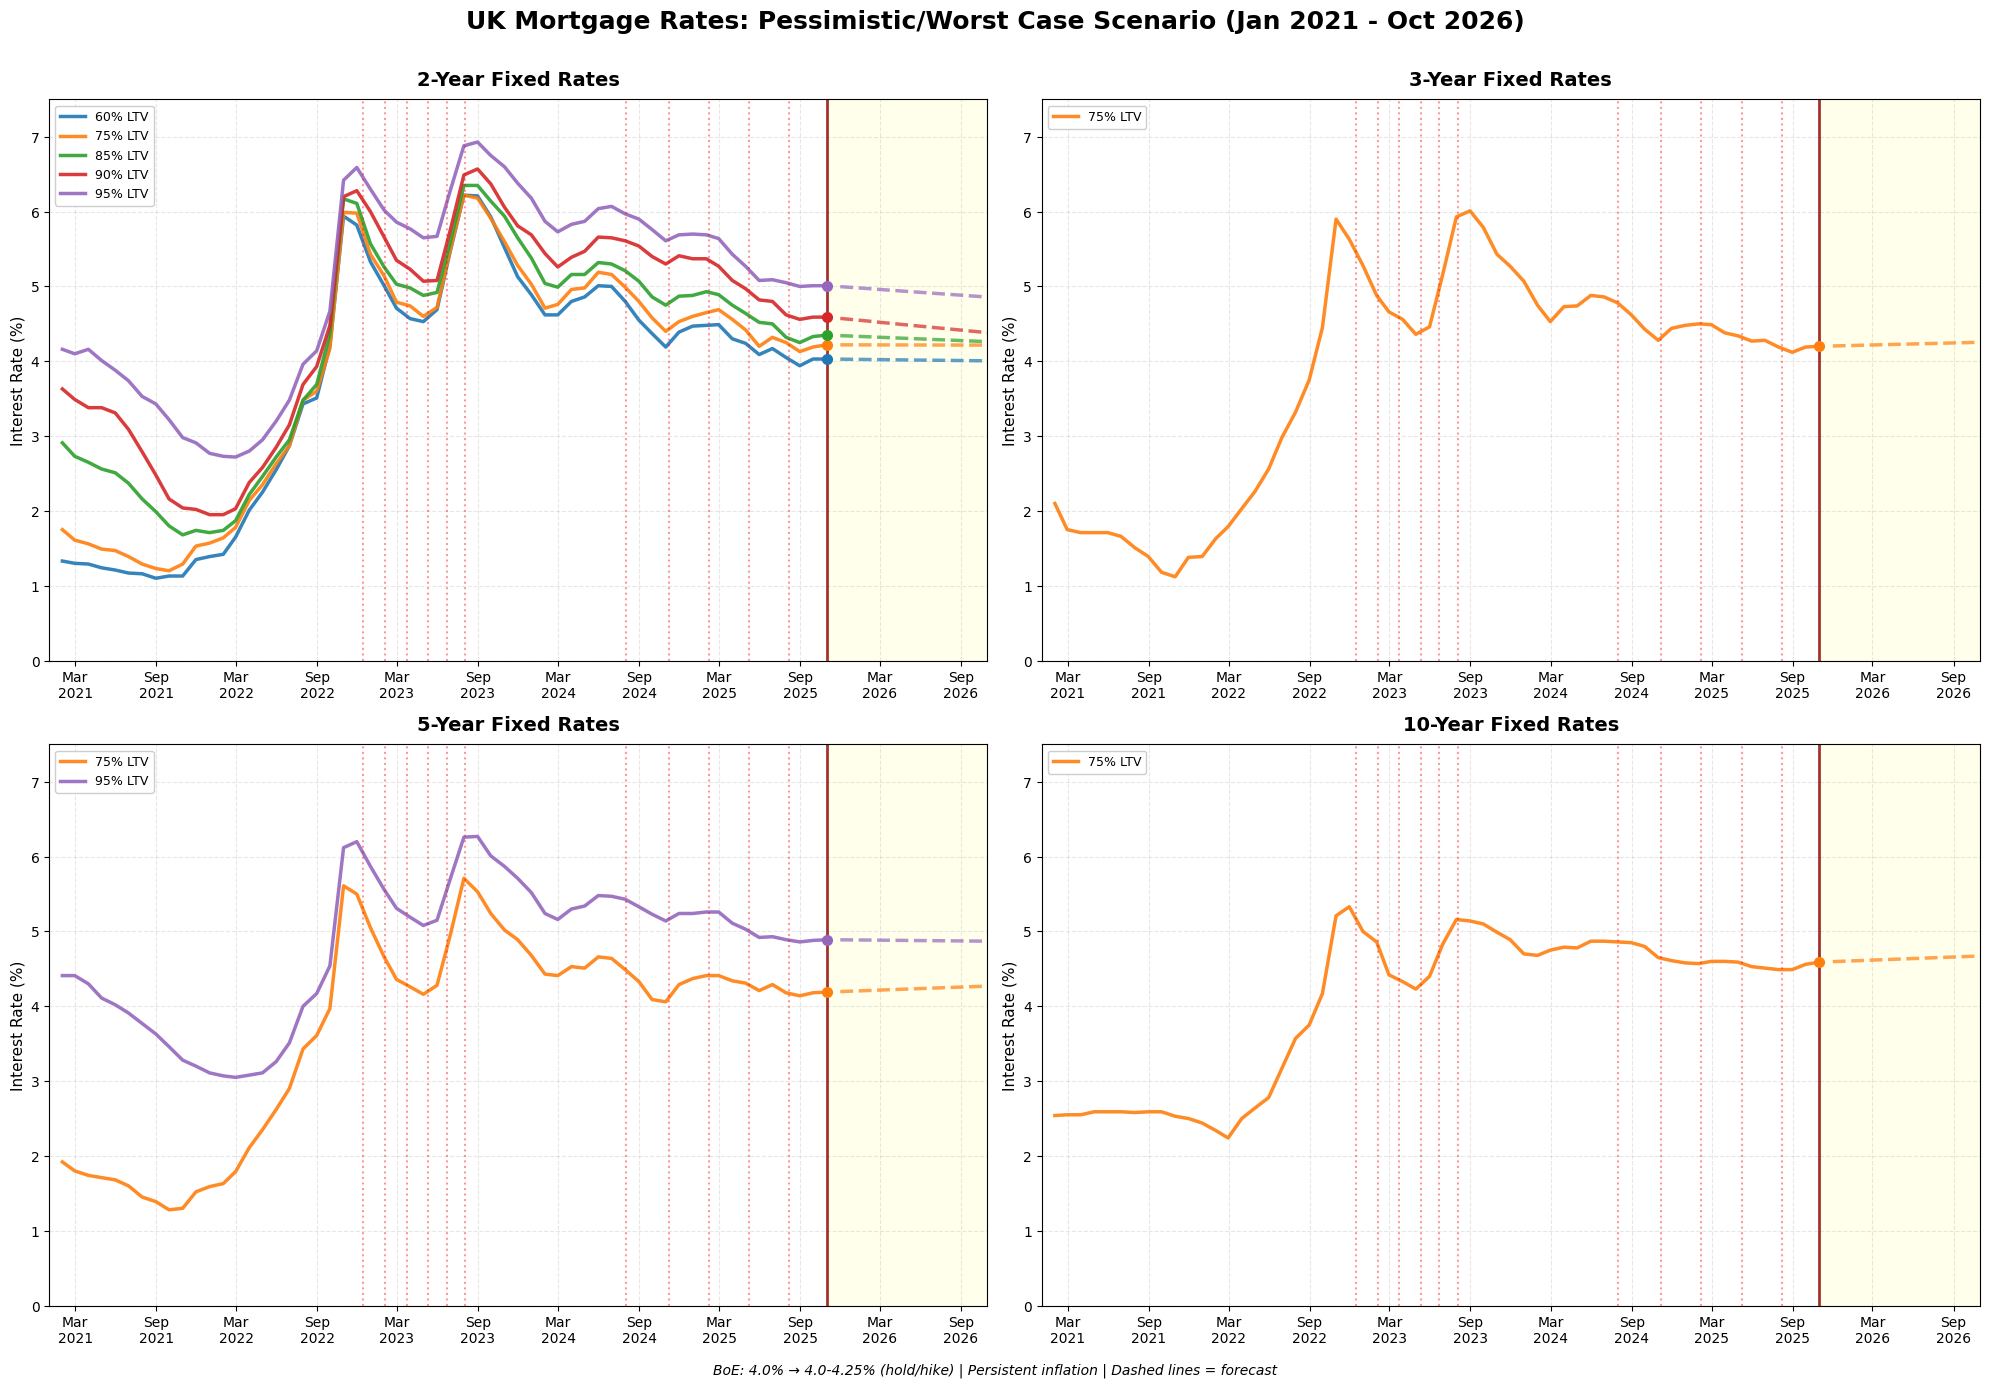

In [41]:
# ========================================
# SCENARIO ANALYSIS WITH ALL LTV LEVELS
# ========================================
# BoE Rate: 4.0% (Dec 2025) - Recent cuts from 5.25% (Aug 2024)

def create_scenario_forecast(col, months=12, scenario='base'):
    """Generate forecast starting from last actual data point"""
    temp = df.copy()
    temp[col] = pd.to_numeric(temp[col], errors='coerce')
    clean = temp[[col, 'Date']].dropna()
    
    if len(clean) < 12:
        return None, None
    
    recent = clean.tail(12)
    last_value = recent[col].iloc[-1]
    last_date = clean['Date'].max()
    trend_slope = (recent[col].iloc[-1] - recent[col].iloc[0]) / 12
    
    # Scenario adjustments (BoE pass-through to mortgage rates)
    if scenario == 'optimistic':
        # BoE: 4.0% → 2.75% (faster cuts)
        adj = -0.65 if '2yr' in col else -0.60 if '3yr' in col else -0.55 if '5yr' in col else -0.45
    elif scenario == 'pessimistic':
        # BoE: 4.0% → 4.25% (hold or hike)
        adj = 0.20 if '2yr' in col else 0.25 if '3yr' in col else 0.20 if '5yr' in col else 0.15
    else:  # base
        # BoE: 4.0% → 3.5% (2 cuts)
        adj = -0.35 if '2yr' in col else -0.30 if '3yr' in col else -0.25 if '5yr' in col else -0.15
    
    # Generate smooth forecast curve
    predictions = []
    for i in range(1, months + 1):
        trend_val = last_value + trend_slope * i
        target_val = last_value + (adj * i / months)
        pred = 0.4 * trend_val + 0.6 * target_val
        predictions.append(pred)
    
    predictions = np.array(predictions)
    predictions = np.clip(predictions, max(2.5, last_value - 1.5), last_value + 0.8)
    
    future_dates = pd.date_range(start=last_date + timedelta(days=31), periods=months, freq='MS')
    return future_dates, predictions


def create_scenario_dashboard(scenario='base', title_suffix=''):
    """Create 2x2 dashboard with all LTV levels"""
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle(f'UK Mortgage Rates: {title_suffix} (Jan 2021 - Oct 2026)', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    products = [
        ('2-Year Fixed Rates', ['2yr_60LTV_Fixed', '2yr_75LTV_Fixed', '2yr_85LTV_Fixed', '2yr_90LTV_Fixed', '2yr_95LTV_Fixed']),
        ('3-Year Fixed Rates', ['3yr_75LTV_Fixed']),
        ('5-Year Fixed Rates', ['5yr_75LTV_Fixed', '5yr_95LTV_Fixed']),
        ('10-Year Fixed Rates', ['10yr_75LTV_Fixed'])
    ]
    
    colors = {'60LTV': '#1f77b4', '75LTV': '#ff7f0e', '85LTV': '#2ca02c', 
              '90LTV': '#d62728', '95LTV': '#9467bd'}
    
    for idx, (title, rate_cols) in enumerate(products):
        ax = axes[idx // 2, idx % 2]
        df_filtered = df[df['Date'] >= '2021-01-01'].copy()
        last_date = df_filtered['Date'].max()
        forecast_end = last_date + timedelta(days=365)
        
        for col in rate_cols:
            if col not in df_filtered.columns:
                continue
            
            ltv = col.split('_')[1].replace('LTV', '')
            color = colors.get(f'{ltv}LTV', 'gray')
            label = f'{ltv}% LTV'
            
            # Plot historical data
            ax.plot(df_filtered['Date'], df_filtered[col], 
                   label=label, color=color, linewidth=2.5, alpha=0.9)
            
            # Generate and plot forecast (starts from last data point)
            future_dates, predictions = create_scenario_forecast(col, months=12, scenario=scenario)
            if future_dates is not None:
                # Connect forecast to last actual value
                last_value = df_filtered[df_filtered['Date'] == last_date][col].values[0]
                
                # Plot forecast line
                ax.plot(future_dates, predictions, 
                       linestyle='--', color=color, linewidth=2.5, alpha=0.7)
                
                # Mark transition point
                ax.plot(last_date, last_value, 'o', color=color, markersize=7, zorder=5)
        
        # BoE rate markers
        for date in boe_rate_changes:
            if pd.to_datetime(date) >= pd.to_datetime('2021-01-01'):
                ax.axvline(x=pd.to_datetime(date), color='red', linestyle=':', alpha=0.4, linewidth=1.5)
        
        # Forecast period shading
        ax.axvspan(last_date, forecast_end, alpha=0.08, color='yellow')
        ax.axvline(x=last_date, color='darkred', linestyle='-', linewidth=2, alpha=0.8)
        
        # Format
        ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
        ax.set_ylabel('Interest Rate (%)', fontsize=11)
        ax.set_xlim(pd.Timestamp('2021-01-01'), forecast_end)
        ax.set_ylim(0, 7.5)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='upper left', fontsize=9, framealpha=0.95)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    
    # Footer
    if scenario == 'optimistic':
        footer = "BoE: 4.0% → 2.75-3.0% (5-6 cuts) | Rapid disinflation | Dashed lines = forecast"
    elif scenario == 'pessimistic':
        footer = "BoE: 4.0% → 4.0-4.25% (hold/hike) | Persistent inflation | Dashed lines = forecast"
    else:
        footer = "BoE: 4.0% → 3.5% (2 cuts by Oct 2026) | Dashed lines = forecast | Source: Bank of England"
    
    fig.text(0.5, 0.02, footer, ha='center', fontsize=10, style='italic')
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])
    plt.show()


# Generate all three scenario dashboards
print("="*80)
print("GENERATING SCENARIO ANALYSIS DASHBOARDS")
print("="*80)

print("\n1. BASE CASE SCENARIO (Current Forecast)")
print("-" * 80)
create_scenario_dashboard(scenario='base', title_suffix='Base Case Scenario')

print("\n2. OPTIMISTIC SCENARIO (Faster Rate Cuts)")
print("-" * 80)
create_scenario_dashboard(scenario='optimistic', title_suffix='Optimistic Scenario')

print("\n3. PESSIMISTIC SCENARIO (Rates Stay Elevated)")
print("-" * 80)
create_scenario_dashboard(scenario='pessimistic', title_suffix='Pessimistic/Worst Case Scenario')